# Machine Learning (laboratory instruction)
## Classification metrics

### Submission

<u>Submission:</u>

Compress all files into **single zip** archive and submit via Wikamp. See below the content of the archive (replace the `name` and `surname` with proper values):
```
📂 name.surname.zip
+-- 📜 05-Multiclass classification.ipynb
```

<u>Grades</u>

| Percentage of all points | mark |
| :----                    | ---: |
| [0-50)   | 2   |
| [50-60)  | 3   |
| [60-70)  | 3.5 |
| [70-80)  | 4   |
| [80-90)  | 4.5 |
| [90-100] | 5   |

<u>Penalties</u>

* `mark - 0.5` if tasks are submitted after laboratory (but less than 7 days); 
* `mark - 1` if tasks are submitted after one week (>=7 days but < 14 days);
* `mark - 1.5` if tasks are submitted later than two weeks (>=14 days).

<u>Warning:</u>

It is NOT allowed to share your .ipynb file with other students nor Internet. All students should download the exercise files directly from WIKAMP. Group work is considered as plagiarism.

<u>Plagiarism Disclaimer:</u>

I hereby declare that this exercise is my own and autonomous work. I am aware of the consequences and I am familiar with the university regulations.

### The goal.

Multi-class classification.

In previous laboratory you made a binary classifier. Such classifier assigns one of two labels to samples. In many machine learning applications there is a need to classify samples into more than two groups. This kind of classification is called multi-class classification.

### Task 0. Read the data.

Read the data from file `animals.npz`.
It is a data read from 20 sensors attached to the animal head. The sensors were put on multiple animals, and data has been collected and annotated.

**Tip**: You can use below code to read the data:

```python
import sklearn.datasets
import numpy as np
from tqdm import tqdm

with open('animals.npz', 'rb') as f:
    data = np.load(f)
    x_train, x_test, y_train, y_test, classes = data['x_train'], data['x_test'], data['y_train'], data['y_test'], data['classes']
```
```



In [1]:
# >>> WRITE YOUR CODE BELOW <<<
import sklearn.datasets
import numpy as np
from tqdm import tqdm

with open('animals.npz', 'rb') as f:
    data = np.load(f)
    x_train, x_test, y_train, y_test, classes = data['x_train'], data['x_test'], data['y_train'], data['y_test'], data['classes']
print(classes)
print(x_train.shape)
x_train = np.hstack((np.ones(len(x_train)).reshape(-1, 1), x_train))
x_test = np.hstack((np.ones(len(x_test)).reshape(-1, 1), x_test))

['cat' 'dog' 'mouse' 'monkey']
(500, 20)



### Task 1. Data preprocessing - one-hot encoding.
To perform multi-class classification we need to prepare the data. We are about to predict the probability that particular sample belongs to one of $k$ classes. In this case, we expect that the result contains $k$ numbers where each tells the probability that the sample belongs to such class. Perfectly, if the sample belongs to the class the model returns 1 and zeros for other classes.

Before we start training the data should be prepared properly. For this case implement one-hot encoding function that will perform the below operation:

$$
\begin{align}
z_{i=0 \cdots k-1}(x) = \begin{cases}
1&\text{if $x=i$}\\
0&\text{if otherwise}\\
\end{cases}
\end{align}
$$

, where $k$ is the number of classes, $z$ if the one-hot vector and x if the number (index) of class.

Example ($k=6$):

| x     | z           |
| :---- |       ---:  |
| 2     | 0 0 1 0 0 0 |
| 5     | 0 0 0 0 0 1 |
| 1     | 0 1 0 0 0 0 |
| 0     | 1 0 0 0 0 0 |

*Note: it is worth to add bias feature at this point.*

In [2]:
# >>> WRITE YOUR CODE BELOW <<<
def to_one_hot(labels, n_classes):
    one_hot = np.zeros(shape=(labels.shape[0], n_classes))
    for i, label in enumerate(labels):
        one_hot[i][label] = 1
    return one_hot

y_train = to_one_hot(y_train, len(classes))
y_test = to_one_hot(y_test, len(classes))
print(y_train, y_test)

[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]] [[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


### Task 2. Softmax.

The logistic regression uses the sigmoid function to classify the sample into one of two groups. This time we want to assign one of >2 labels to sample. For this case, implement the softmax function that returns a vector of probabilities:

$$
\sigma(z)_i = \frac{e^{z_i}}{\sum_{j}^{k-1}e^{z_j}}
$$

, where $z$ is the vector that contains the scores, and $k$ is the number of classes.

*Note: $\sum\sigma(z) = 1$.*

In [13]:
# >>> WRITE YOUR CODE BELOW <<<
def softmax(x):
    e_x = np.exp(x - np.max(x)) #prevent overflow
    out = e_x / e_x.sum(axis=0)
    return out



### Task 3. Train the model.

To train the model we will use the cross-entropy cost function:

$$
c(\theta) =
- \dfrac{1}{m}\sum\limits_{i=0}^{m-1}\sum\limits_{k=0}^{K-1}{t_k^{(i)}\log\left(y_k^{(i)}\right)}
$$

, where $K$ is the number of classes, $m$ is the number of samples, $t$ is the ground truth (expected) values, $y$ is the prediction (predicted values).

The equation for the gradient:

$$
\nabla_{\mathbf{\theta}^{(k)}} \, c(\theta) = \dfrac{1}{m} \sum\limits_{i}^{m-1}{ \left ( y^{(i)}_k - t_k^{(i)} \right ) \mathbf{x}^{(i)}}
$$

*Note: the $log(0)$ returns `-inf`, so you may need to add tiny value to avoid it.*

*Note 2: for vectorized form you may need to specify the `axis` parameter for functions such as `sum` or `mean`.*

In [57]:
# >>> WRITE YOUR CODE BELOW <<<
def crossentropy(predictions, targets, l2=0, weights=0):
    m = predictions.shape[0]
    entropy = np.sum(targets*np.log(predictions + 1e-9)) #epsilon to prevent -inf
    return (-1 / m) * entropy + l2 * np.linalg.norm(weights)**2

def grad(x, predictions, targets, l2=0, weights=0):
    m = predictions.shape[0]
    s = (1 / m) * (x.T @ np.subtract(predictions, targets)) 
    return s + (2 * l2 * weights)

def accuracy(predictions, targets):
    z = np.argmax(predictions, axis = 1)
    t = np.argmax(targets, axis = 1)
    #print(np.count_nonzero((z==t) == True), len(t))
    return np.mean(z == t)

### Task 4. Results.

* Display the training and testing loss.
* Calculate the accuracy score.

Final error (train): 7.0955973883392875 | Final error (test): 7.145669922556907 
Final weights: [[ 1.87142938e-01  1.84285907e-01  1.77143182e-01  1.60000066e-01]
 [-2.65295322e-02  4.73299952e-03 -1.14380605e-02 -4.03054620e-03]
 [-1.81826627e-01  1.98271179e-01  1.01647292e-02  8.46142895e-03]
 [ 2.04824212e-02 -5.91479513e-06  1.79299399e-02  9.89255704e-04]
 [-1.49346869e-02 -1.91312454e-02 -5.75457130e-03  1.16248830e-02]
 [-1.44704970e-02 -2.11821604e-01  1.88494216e-01 -1.22524865e-02]
 [ 5.51752921e-03  4.29570486e-03 -2.37555120e-02  1.15421864e-02]
 [ 5.84510404e-03  1.11633413e-02 -6.59319857e-03  2.33642120e-02]
 [-1.27279342e-01  2.02409471e-01 -1.48157640e-01 -2.80098135e-01]
 [ 2.19462459e-03  1.45232343e-01 -7.50744949e-03 -3.41840730e-02]
 [ 4.23849217e-03  1.66097724e-02  7.29112818e-03  2.07956666e-02]
 [-2.08685912e-01  1.26154609e-02 -1.67426099e-01 -1.02107942e-02]
 [-1.88926364e-01  1.89626046e-03 -1.59959446e-01  5.53821389e-03]
 [-1.20064787e-02 -1.47060146e-01

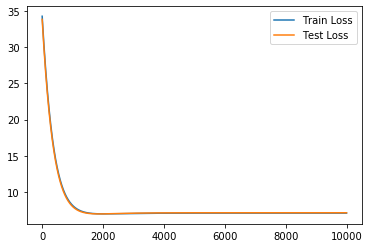

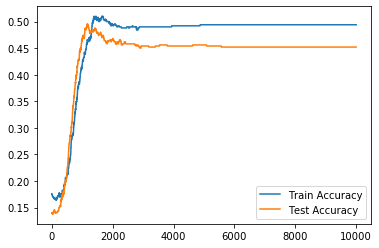

In [59]:
# >>> WRITE YOUR CODE BELOW <<<
import matplotlib.pyplot as plt

w = np.random.uniform(size=(21, len(classes)))
lr = 1e-3
epochs = 10_000
l = 0.7
history = {'train': [], 'test': []}
acc = {'train': [], 'test': []}
for i in range(epochs):
    z = x_train @ w
    train_predictions = softmax(z)
    error = crossentropy(train_predictions, y_train, l2=l, weights=w)
    w -= lr * grad(x_train, train_predictions, y_train, l2=l, weights=w)
    history['train'].append(error)
    acc['train'].append(accuracy(train_predictions, y_train))
    

    z = x_test @ w
    test_predictions = softmax(z)
    test_error = crossentropy(test_predictions, y_test, l2=l, weights=w)
    history['test'].append(test_error)
    acc['test'].append(accuracy(test_predictions, y_test))
    
print(f'Final error (train): {history["train"][-1]} | Final error (test): {history["test"][-1]} ')
print(f'Final weights: {w}')
plt.plot(history['train'], label='Train Loss')
plt.plot(history['test'], label='Test Loss')
plt.legend()
plt.show()

plt.plot(acc['train'], label='Train Accuracy')
plt.plot(acc['test'], label='Test Accuracy')
plt.legend()
plt.show()
